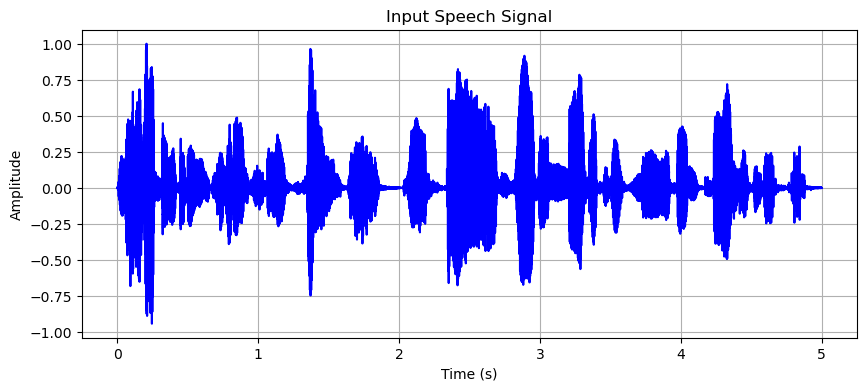

In [29]:
# plot the speech signal


import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Load the .wav file
file_path = "C:\\Users\\ssshr\\Downloads\\LJSpeech-1.1\\wavs\\LJ001-0083.wav"  # Replace this with your file path
sample_rate, data = wavfile.read(file_path)

# Normalize the data
normalized_data = data / np.max(np.abs(data))

# Create the time axis
time = np.arange(0, len(data)) / sample_rate

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time, normalized_data, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input Speech Signal')
plt.grid(True)
plt.show()

In [13]:
# split the speech into windows for short time analysis 
def split_into_windows(data, window_size, overlap):
    """
    Split the data into windows with specified size and overlap.
    """
    window_shift = window_size - overlap
    num_windows = (len(data) - window_size) // window_shift + 1
    windows = [data[i*window_shift:i*window_shift+window_size] for i in range(num_windows)]
    return windows

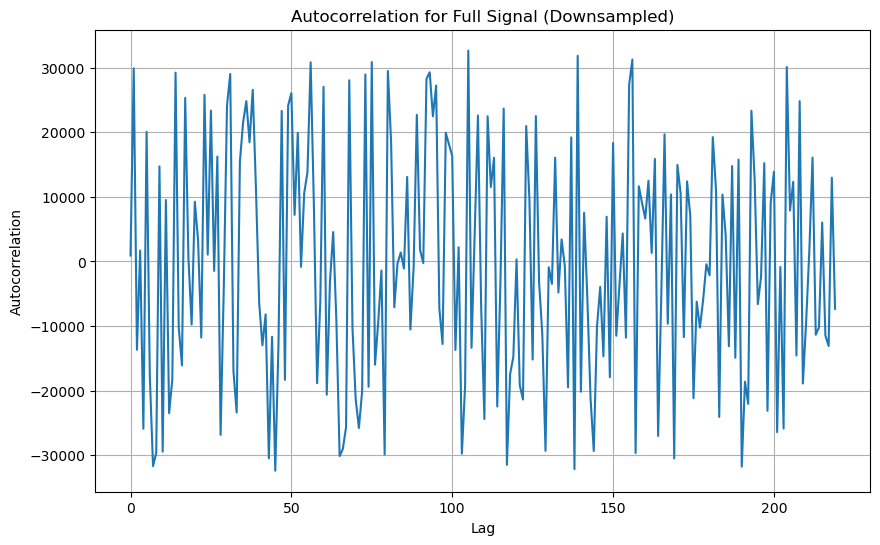

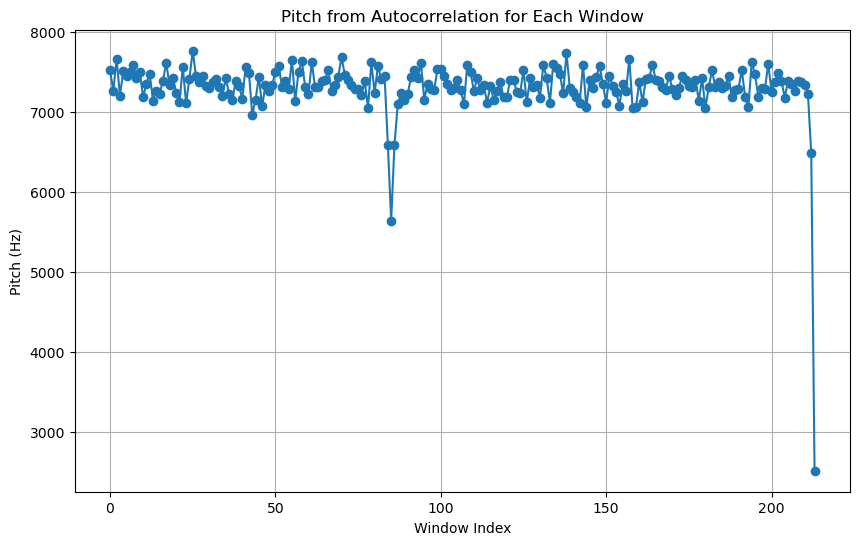

In [20]:
# compute short-time autocorrelation
from scipy.signal import find_peaks
def autocorr(x):
    """
    Compute autocorrelation of the signal.
    """
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

def calculate_pitch_from_autocorr(autocorr, sample_rate):
    """
    Calculate pitch from autocorrelation function.
    """
    # Exclude the peak at zero lag
    autocorr[0] = 0
    
    # Find peaks in autocorrelation
    peaks, _ = find_peaks(autocorr)

    # Calculate average distance between peaks (excluding zero lag)
    pitch_period = np.mean(np.diff(peaks)) / sample_rate

    # Calculate pitch (fundamental frequency)
    pitch_hz = 1 / pitch_period

    return pitch_hz

# Load the .wav file
sample_rate, data = wavfile.read(file_path)

# Parameters
window_size = 1024  # Size of each window
overlap = 512      # Overlap between consecutive windows

# Split data into windows
windows = split_into_windows(data, window_size, overlap)

autocorr_full = np.concatenate([autocorr(window) for window in windows])

# Downsample the autocorrelation signal to reduce density
downsample_factor = 1000
autocorr_full_downsampled = autocorr_full[::downsample_factor]

# Plot autocorrelation for the full signal
plt.figure(figsize=(10, 6))
plt.plot(autocorr_full_downsampled)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Full Signal (Downsampled)')
plt.grid(True)
plt.show()


# Calculate pitch for each window
pitches = []
for window in windows:
    autocorr_window = autocorr(window)
    pitch_hz = calculate_pitch_from_autocorr(autocorr_window, sample_rate)
    pitches.append(pitch_hz)

plt.figure(figsize=(10, 6))
plt.plot(pitches, marker='o')
plt.xlabel('Window Index')
plt.ylabel('Pitch (Hz)')
plt.title('Pitch from Autocorrelation for Each Window')
plt.grid(True)
plt.show()

# implement center clipping in autocorrelation

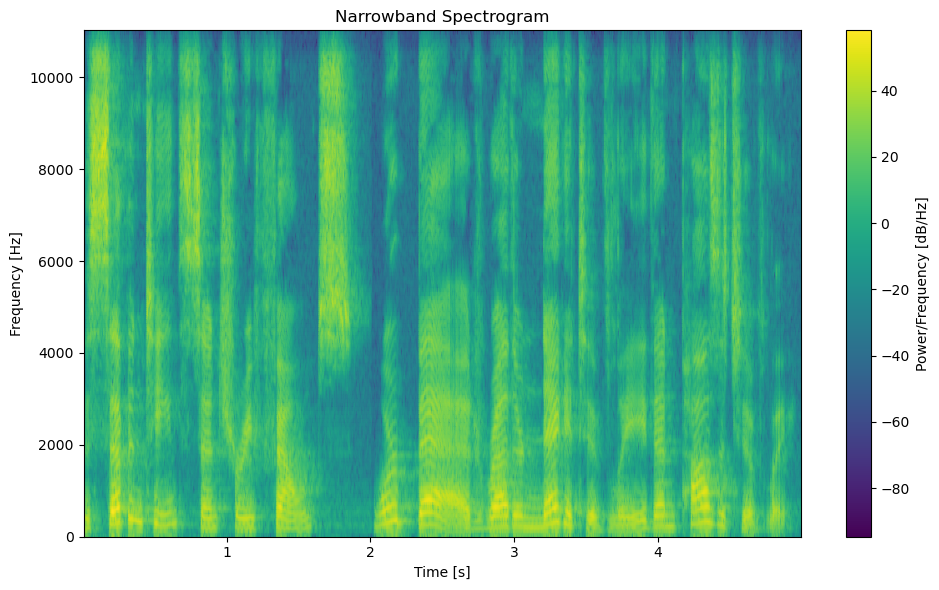

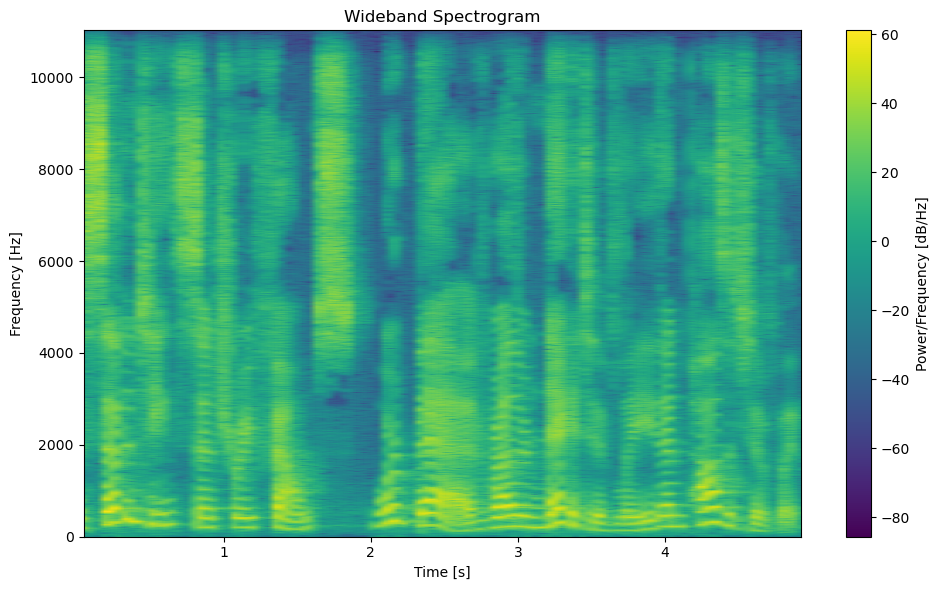

In [22]:
from scipy.signal import spectrogram
# Parameters for spectrogram
n_fft_narrow = 256  # Narrowband FFT window size
n_fft_wide = 2048   # Wideband FFT window size
overlap_narrow = 128 # Narrowband overlap
overlap_wide = 1024  # Wideband overlap

# Compute narrowband spectrogram
frequencies_narrow, times_narrow, Sxx_narrow = spectrogram(data, fs=sample_rate, nperseg=n_fft_narrow, noverlap=overlap_narrow)

# Compute wideband spectrogram
frequencies_wide, times_wide, Sxx_wide = spectrogram(data, fs=sample_rate, nperseg=n_fft_wide, noverlap=overlap_wide)

# Plot narrowband spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times_narrow, frequencies_narrow, 10 * np.log10(Sxx_narrow), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Narrowband Spectrogram')
plt.colorbar(label='Power/Frequency [dB/Hz]')
plt.tight_layout()
plt.show()

# Plot wideband spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times_wide, frequencies_wide, 10 * np.log10(Sxx_wide), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Wideband Spectrogram')
plt.colorbar(label='Power/Frequency [dB/Hz]')
plt.tight_layout()
plt.show()

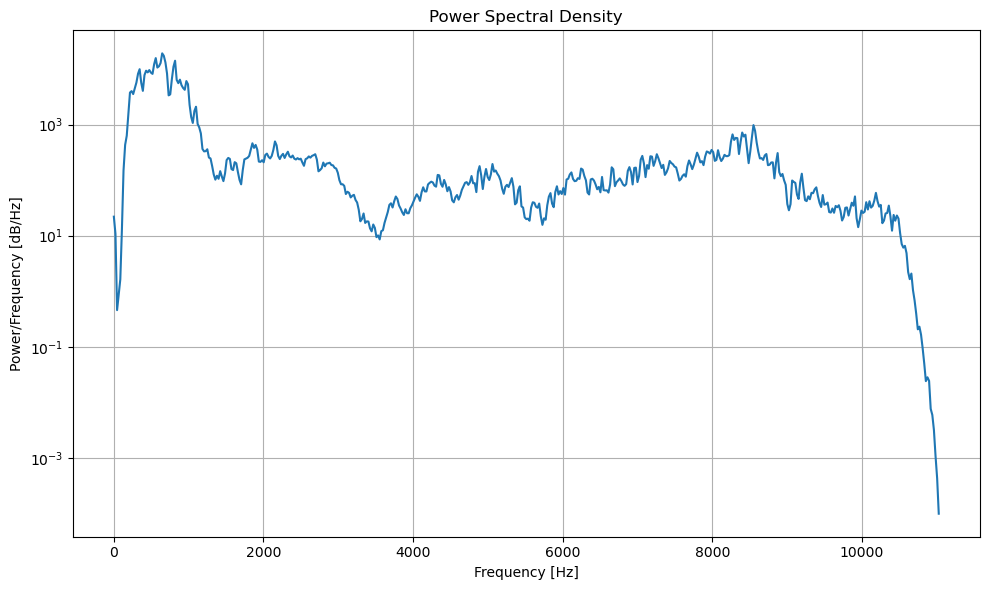

In [23]:
from scipy.signal import welch

frequencies, psd = welch(data, fs=sample_rate, nperseg=1024)

# Plot power spectral density
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Power Spectral Density')
plt.grid(True)
plt.tight_layout()
plt.show()

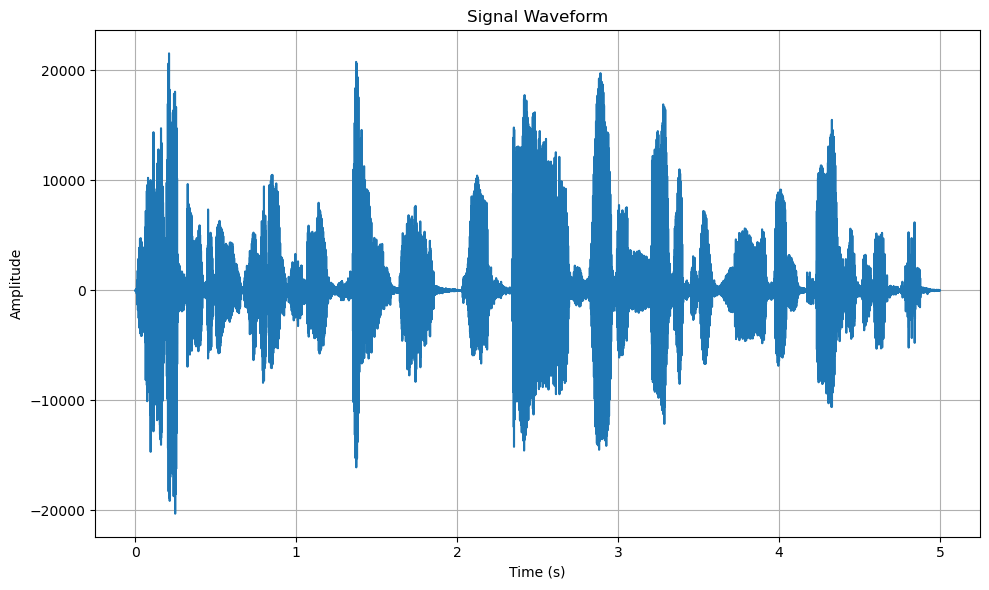

RMS Amplitude (loudness): 33.83002250688426
Sound Pressure Level (SPL): 124.5654458211453 dB


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Calculate RMS amplitude (loudness)
rms_amplitude = np.sqrt(np.mean(data**2))

# Calculate sound pressure level (SPL) in dB
reference_pressure = 20e-6  # Reference sound pressure level (20 microPascals)
sound_pressure_level = 20 * np.log10(rms_amplitude / reference_pressure)

# Calculate loudness level (not implemented here, requires psychoacoustic models)

# Plot the signal waveform
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)) / sample_rate, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal Waveform')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"RMS Amplitude (loudness): {rms_amplitude}")
print(f"Sound Pressure Level (SPL): {sound_pressure_level} dB")


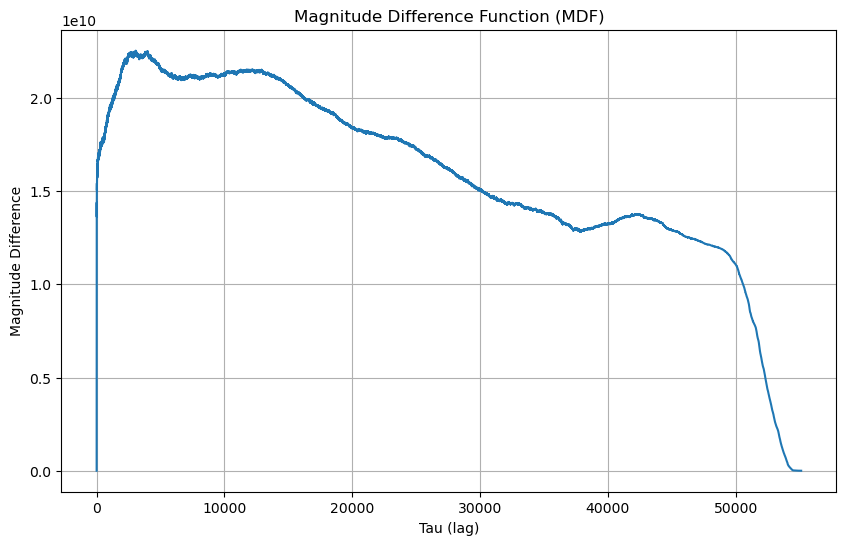

In [26]:
# amdf 
# Function to compute magnitude spectrum
# Load the .wav file
sample_rate, data = wavfile.read(file_path)

def compute_magnitude_spectrum(signal, sample_rate):
    spectrum = np.abs(np.fft.fft(signal))
    freqs = np.fft.fftfreq(len(signal), 1 / sample_rate)
    return freqs[:len(freqs)//2], spectrum[:len(spectrum)//2]

# Compute magnitude spectrum
freqs, spectrum = compute_magnitude_spectrum(data, sample_rate)

# Compute Magnitude Difference Function (MDF)
def compute_mdf(spectrum):
    mdf = np.zeros(len(spectrum))
    for tau in range(1, len(spectrum)):
        mdf[tau] = np.sum(np.abs(spectrum[:-tau] - spectrum[tau:]))
    return mdf

# Calculate MDF
mdf = compute_mdf(spectrum)

# Plot MDF
plt.figure(figsize=(10, 6))
plt.plot(mdf)
plt.xlabel('Tau (lag)')
plt.ylabel('Magnitude Difference')
plt.title('Magnitude Difference Function (MDF)')
plt.grid(True)
plt.show()

In [32]:
from scipy.signal import lfilter, hann

# Apply windowing (Hann window)
window = hann(len(data))
data_windowed = data * window

# Compute autocorrelation
autocorr = np.correlate(data_windowed, data_windowed, mode='full')

# Normalize the autocorrelation
autocorr /= np.max(autocorr)

# Levinson-Durbin recursion algorithm
def levinson_durbin(autocorr, order):
    # Initialize variables
    A = np.zeros(order + 1)
    E = np.zeros(order + 1)
    k = np.zeros(order + 1)
    
    # Initialization step
    E[0] = autocorr[0]
    for m in range(1, order + 1):
        k[m] = -np.sum(A[:m] * autocorr[m:0:-1]) / E[m - 1]
        A[m] = k[m]
        for i in range(1, m):
            A[i] = A[i] + k[m] * A[m - i]
        E[m] = (1 - k[m]**2) * E[m - 1]
    
    return A[1:], k[1]

# Compute LPC coefficients
order = 12  # Adjust order as needed
lpc_coeffs, first_refl_coeff = levinson_durbin(autocorr, order)

print("LPC Coefficients:", lpc_coeffs)
print("First Reflection Coefficient:", first_refl_coeff)

C:\Users\ssshr\AppData\Local\Temp\ipykernel_25044\3611314825.py:4: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated since SciPy 1.1.0 and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(len(data))


LPC Coefficients: [nan nan nan nan nan nan nan nan nan nan nan nan]
First Reflection Coefficient: nan


C:\Users\ssshr\AppData\Local\Temp\ipykernel_25044\3611314825.py:23: RuntimeWarning: invalid value encountered in double_scalars
  k[m] = -np.sum(A[:m] * autocorr[m:0:-1]) / E[m - 1]
